In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rna_motif_library.plotting import publication_style_ax
from rna_motif_library.util import parse_motif_name, get_nucleotide_atom_type, add_motif_name_columns


In [2]:
df = pd.read_csv("../rna_protein_hbonds.csv")
df["res_type_1"] = df["res_1"].str.split("-").str[1]
df["res_type_2"] = df["res_2"].str.split("-").str[1]
df["atom_type_1"] = df["atom_1"].apply(get_nucleotide_atom_type)

In [3]:
df_counts = pd.read_csv("../data/csvs/rna_residue_counts.csv")

In [4]:
df_gini = pd.read_csv("../rna_protein_hbonds_normalized_gini.csv")
df_motifs = pd.read_json("../rna_protein_hbonds_motifs.json")
df_motifs["num_hbonds"] = df_motifs["hbonds"].apply(len)
add_motif_name_columns(df_motifs, "motif_name")
df_motifs["sequence_length"] = df_motifs["msequence"].apply(len)
df_motifs = df_motifs.merge(df_counts, on="pdb_id", how="left")


In [5]:
df_motifs.query("mtype == 'HAIRPIN' and count < 300 and msequence.str.len() < 25").sort_values("num_hbonds", ascending=False).head(10)

,motif_name,hbonds,num_hbonds,mtype,msize,msequence,pdb_id,sequence_length,count
13454,HAIRPIN-15-CGUAGGCUACAGAGAAG-6DU4-1,"[{'res_1': 'B-G-8-', 'atom_1': 'O6', 'res_2': ...",42,HAIRPIN,15,CGUAGGCUACAGAGAAG,6DU4,17,29
3788,HAIRPIN-10-UGAUCACGAAGG-4PKD-1,"[{'res_1': 'V-C-96-', 'atom_1': 'O2'', 'res_2'...",39,HAIRPIN,10,UGAUCACGAAGG,4PKD,12,54
1097,HAIRPIN-7-AUUGCAAAU-3EPH-1,"[{'res_1': 'E-U-33-', 'atom_1': 'N3', 'res_2':...",38,HAIRPIN,7,AUUGCAAAU,3EPH,9,138
13453,HAIRPIN-13-UGUGGUACAGAGAAG-6DU5-1,"[{'res_1': 'B-G-18-', 'atom_1': 'O2'', 'res_2'...",35,HAIRPIN,13,UGUGGUACAGAGAAG,6DU5,15,25
1116,HAIRPIN-7-AUUGAAAAU-3FOZ-1,"[{'res_1': 'C-U-33-', 'atom_1': 'N3', 'res_2':...",34,HAIRPIN,7,AUUGAAAAU,3FOZ,9,143
15107,HAIRPIN-10-CAUUGCACUCCG-6LAX-1,"[{'res_1': 'A-C-25-', 'atom_1': 'N3', 'res_2':...",33,HAIRPIN,10,CAUUGCACUCCG,6LAX,12,110
1117,HAIRPIN-7-AUUGAAAAU-3FOZ-2,"[{'res_1': 'D-A-37-', 'atom_1': 'N6', 'res_2':...",32,HAIRPIN,7,AUUGAAAAU,3FOZ,9,143
1003,HAIRPIN-7-AUUGAAAAU-2ZXU-1,"[{'res_1': 'C-A-36-', 'atom_1': 'O2P', 'res_2'...",31,HAIRPIN,7,AUUGAAAAU,2ZXU,9,143
10617,HAIRPIN-8-CAAGAAAGAG-5W1H-1,"[{'res_1': 'B-A--15-', 'atom_1': 'N6', 'res_2'...",31,HAIRPIN,8,CAAGAAAGAG,5W1H,10,42
0,HAIRPIN-13-GUAUUGCAGUACCUC-1A9N-1,"[{'res_1': 'Q-G-9-', 'atom_1': 'O2'', 'res_2':...",31,HAIRPIN,13,GUAUUGCAGUACCUC,1A9N,15,48


In [6]:
df.iloc[0]

res_1               B-C-125-
res_2             A-ARG-836-
atom_1                   O2'
atom_2                    NE
distance                2.92
angle_1                142.2
angle_2                137.3
dihedral_angle          30.1
score                  0.927
pdb_id                  6JE3
res_type_1                 C
res_type_2               ARG
atom_type_1            sugar
Name: 0, dtype: object

In [7]:
df_gini.iloc[0]

res_1                          A
res_2                        ALA
atom_1                       O4'
atom_2                         N
num_datapoints               188
normalized_gini         0.750243
mean_score               0.58642
mean_dihedral_angle    68.328191
mean_angle_1              117.45
Name: 0, dtype: object

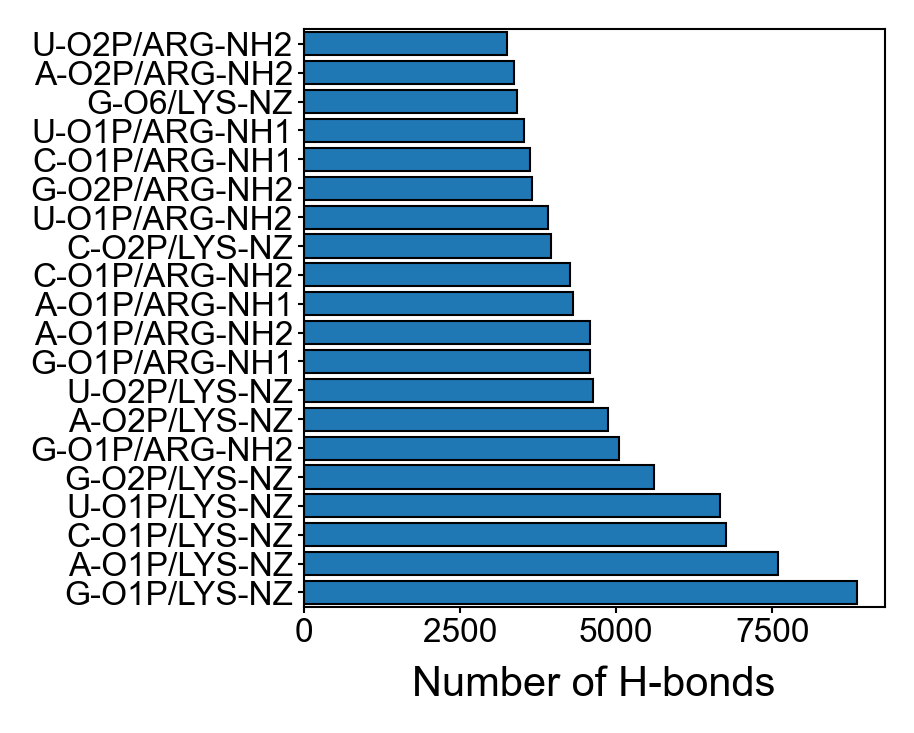

In [8]:
# Sort by count and get top 50
top_50 = df_gini.sort_values("num_datapoints", ascending=False).head(20)

# Create labels by combining res1,atom1,res2,atom2
top_50["label"] = top_50.apply(
    lambda x: f"{x['res_1']}-{x['atom_1']}/{x['res_2']}-{x['atom_2']}", axis=1
)

# Create horizontal bar plot
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)

bars = ax.barh(
    y=range(len(top_50)),
    width=top_50["num_datapoints"],
    edgecolor="black",
    linewidth=0.5,
)

# Customize the plot
ax.set_yticks(range(len(top_50)))
ax.set_yticklabels(top_50["label"])
ax.set_xlabel("Number of H-bonds")
ax.set_ylim(-0.5, len(top_50) - 0.5)  # Remove extra space at top and bottom
publication_style_ax(ax)

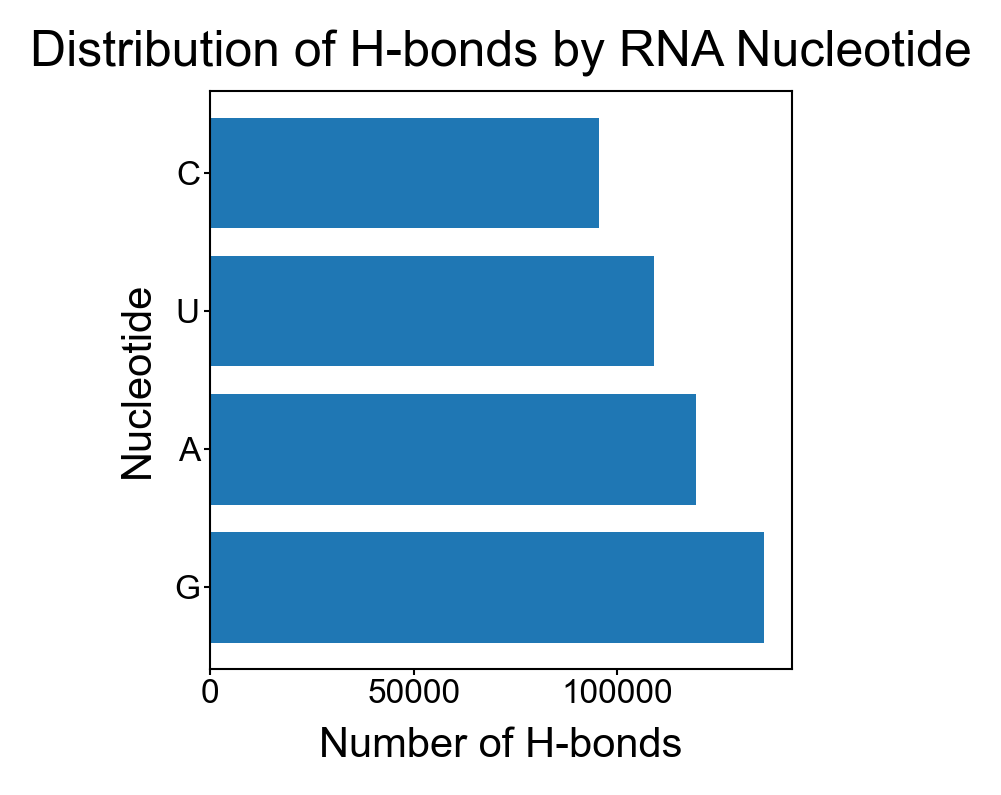

In [9]:
# Create bar plot of nucleotide counts
plt.figure(figsize=(2.5, 2.5), dpi=300)
ax = plt.gca()
publication_style_ax(ax)

counts = df["res_type_1"].value_counts()
bars = ax.barh(counts.index, counts.values)

ax.set_ylabel("Nucleotide")
ax.set_xlabel("Number of H-bonds")
ax.set_title("Distribution of H-bonds by RNA Nucleotide")

plt.show()

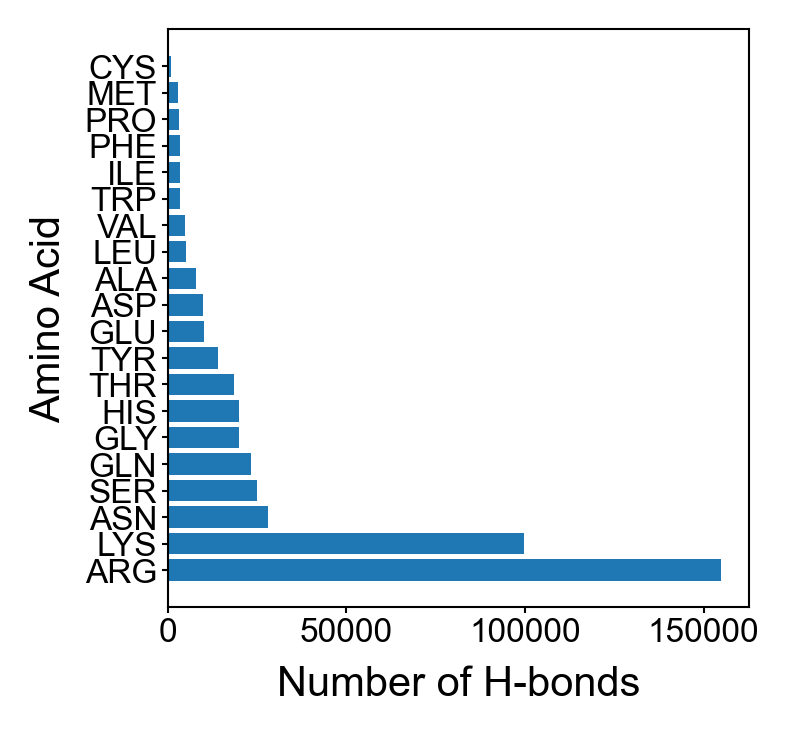

In [10]:
# Create bar plot of nucleotide counts
plt.figure(figsize=(2.5, 2.5), dpi=300)
ax = plt.gca()

counts = df["res_type_2"].value_counts()
tbars = ax.barh(counts.index, counts.values)

ax.set_ylabel("Amino Acid")
ax.set_xlabel("Number of H-bonds")
publication_style_ax(ax)

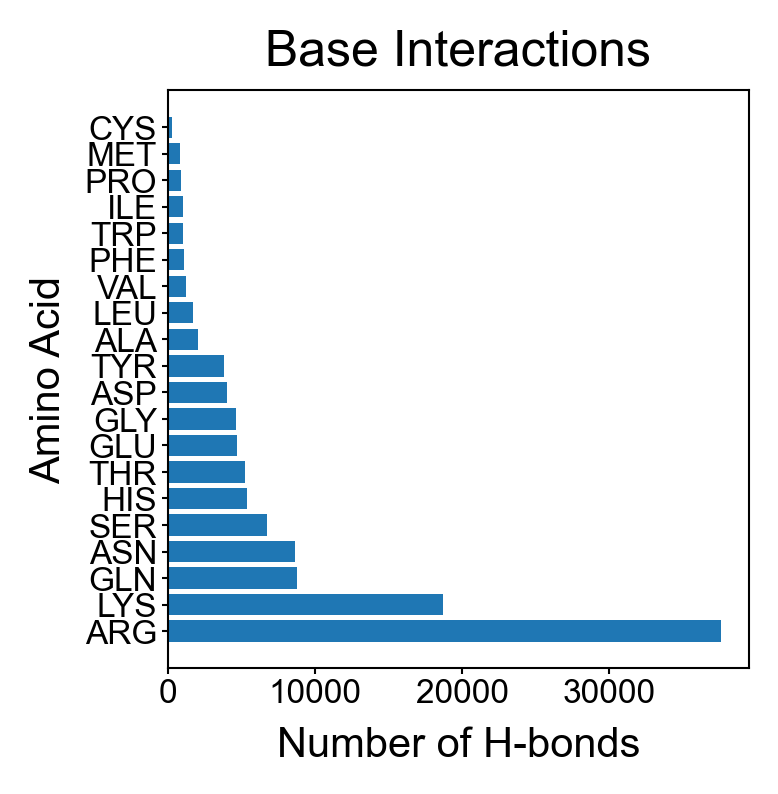

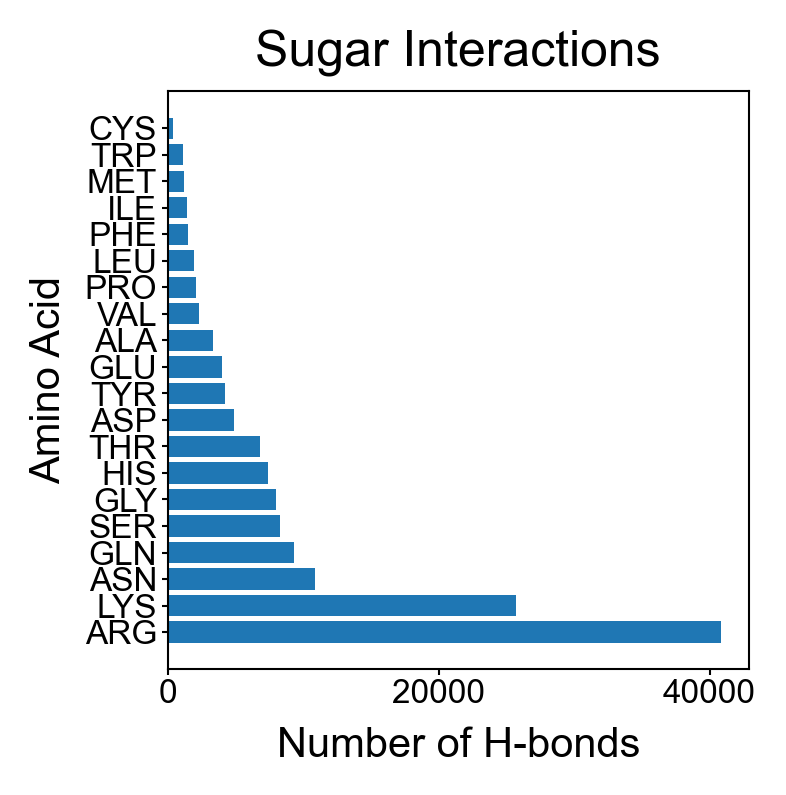

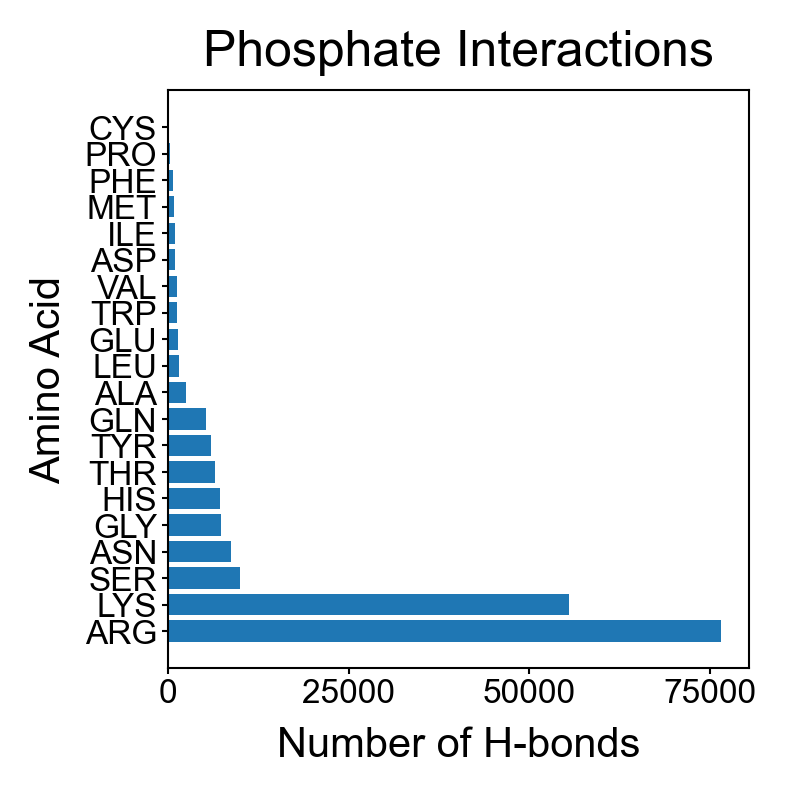

In [11]:
# Base interactions plot
plt.figure(figsize=(2.5, 2.5), dpi=300)
ax = plt.gca()
publication_style_ax(ax)

mask = df["atom_type_1"] == "base"
counts = df[mask]["res_type_2"].value_counts()
tbars = ax.barh(counts.index, counts.values)

ax.set_ylabel("Amino Acid")
ax.set_xlabel("Number of H-bonds") 
ax.set_title("Base Interactions")

plt.show()

# Sugar interactions plot
plt.figure(figsize=(2.5, 2.5), dpi=300)
ax = plt.gca()
publication_style_ax(ax)

mask = df["atom_type_1"] == "sugar"
counts = df[mask]["res_type_2"].value_counts()
tbars = ax.barh(counts.index, counts.values)

ax.set_ylabel("Amino Acid")
ax.set_xlabel("Number of H-bonds")
ax.set_title("Sugar Interactions")

plt.show()

# Phosphate interactions plot
plt.figure(figsize=(2.5, 2.5), dpi=300)
ax = plt.gca()
publication_style_ax(ax)

mask = df["atom_type_1"] == "phos"
counts = df[mask]["res_type_2"].value_counts()
tbars = ax.barh(counts.index, counts.values)

ax.set_ylabel("Amino Acid")
ax.set_xlabel("Number of H-bonds")
ax.set_title("Phosphate Interactions")

plt.show()

In [12]:
df_sub = df_motifs.query("sequence_length < 25 and mtype != 'UNKNOWN'")
df_sub.sort_values("num_hbonds", ascending=False)[200:230]

,motif_name,hbonds,num_hbonds,mtype,msize,msequence,pdb_id,sequence_length,count
2879,SSTRAND-8-UGUAGAUA-3Q0R-1,"[{'res_1': 'B-U-1-', 'atom_1': 'N3', 'res_2': ...",39,SSTRAND,8,UGUAGAUA,3Q0R,8,8
37695,HELIX-10-ACACUCAUGG-CCAUGAGUGU-7XPL-1,"[{'res_1': 'I-G-7-', 'atom_1': 'O2P', 'res_2':...",39,HELIX,10,ACACUCAUGG-CCAUGAGUGU,7XPL,21,72
3788,HAIRPIN-10-UGAUCACGAAGG-4PKD-1,"[{'res_1': 'V-C-96-', 'atom_1': 'O2'', 'res_2'...",39,HAIRPIN,10,UGAUCACGAAGG,4PKD,12,54
42596,NWAY-8-4-0-GAGGACUGCG-CAAGGA-UC-8EUG-1,"[{'res_1': '1-G-615-', 'atom_1': 'N2', 'res_2'...",39,NWAY,8-4-0,GAGGACUGCG-CAAGGA-UC,8EUG,20,3138
33394,NWAY-9-4-1-UGUGGAAGGCA-UCCGGA-UGG-7QIW-1,"[{'res_1': '2-C-617-', 'atom_1': 'O1P', 'res_2...",39,NWAY,9-4-1,UGUGGAAGGCA-UCCGGA-UGG,7QIW,22,3252
34916,SSTRAND-9-CUGUGAAUG-7RZZ-1,"[{'res_1': 'B-U-2-', 'atom_1': 'O4', 'res_2': ...",39,SSTRAND,9,CUGUGAAUG,7RZZ,9,9
22178,TWOWAY-7-5-AAAGCUUAU-GAUUAAU-6YWS-1,"[{'res_1': 'A-G-19-', 'atom_1': 'N2', 'res_2':...",39,TWOWAY,7-5,AAAGCUUAU-GAUUAAU,6YWS,17,2820
58704,TWOWAY-7-6-CAUCUCUAU-AGCUUAUG-9CAI-1,"[{'res_1': 'A5-A-3321-', 'atom_1': 'O2'', 'res...",39,TWOWAY,7-6,CAUCUCUAU-AGCUUAUG,9CAI,18,4849
21097,HAIRPIN-15-GAACUGAAACUGUUCAC-6XU6-1,"[{'res_1': 'B2-G-1745-', 'atom_1': 'O5'', 'res...",39,HAIRPIN,15,GAACUGAAACUGUUCAC,6XU6,17,5916
8327,HELIX-8-GUACGUAC-GUACGUAC-5JB2-1,"[{'res_1': 'Y-A-4-', 'atom_1': 'O1P', 'res_2':...",39,HELIX,8,GUACGUAC-GUACGUAC,5JB2,17,19


Text(0, 0.5, 'Number of H-bonds')

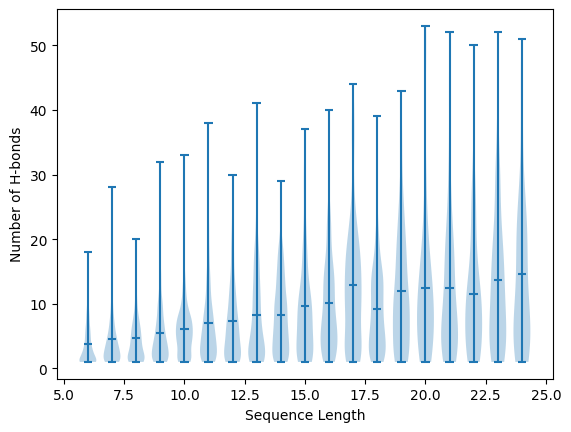

In [13]:
df_sub_2 = df_sub.query("mtype == 'TWOWAY'")
# Group data by sequence length
seq_lengths = sorted(df_sub_2["sequence_length"].unique())
data = [df_sub_2[df_sub_2["sequence_length"]==length]["num_hbonds"].values for length in seq_lengths]

plt.violinplot(data, positions=seq_lengths,
               points=100, widths=0.7, showmeans=True, showextrema=True)
plt.xlabel("Sequence Length")
plt.ylabel("Number of H-bonds")


In [14]:
hbonds = []
for i, row in df_sub.iterrows():
    for hbond in row["hbonds"]:
        aa = hbond['res_2'].split("-")[1]
        hbonds.append([aa, row['mtype']])
df_hbonds = pd.DataFrame(hbonds, columns=["aa", "mtype"])


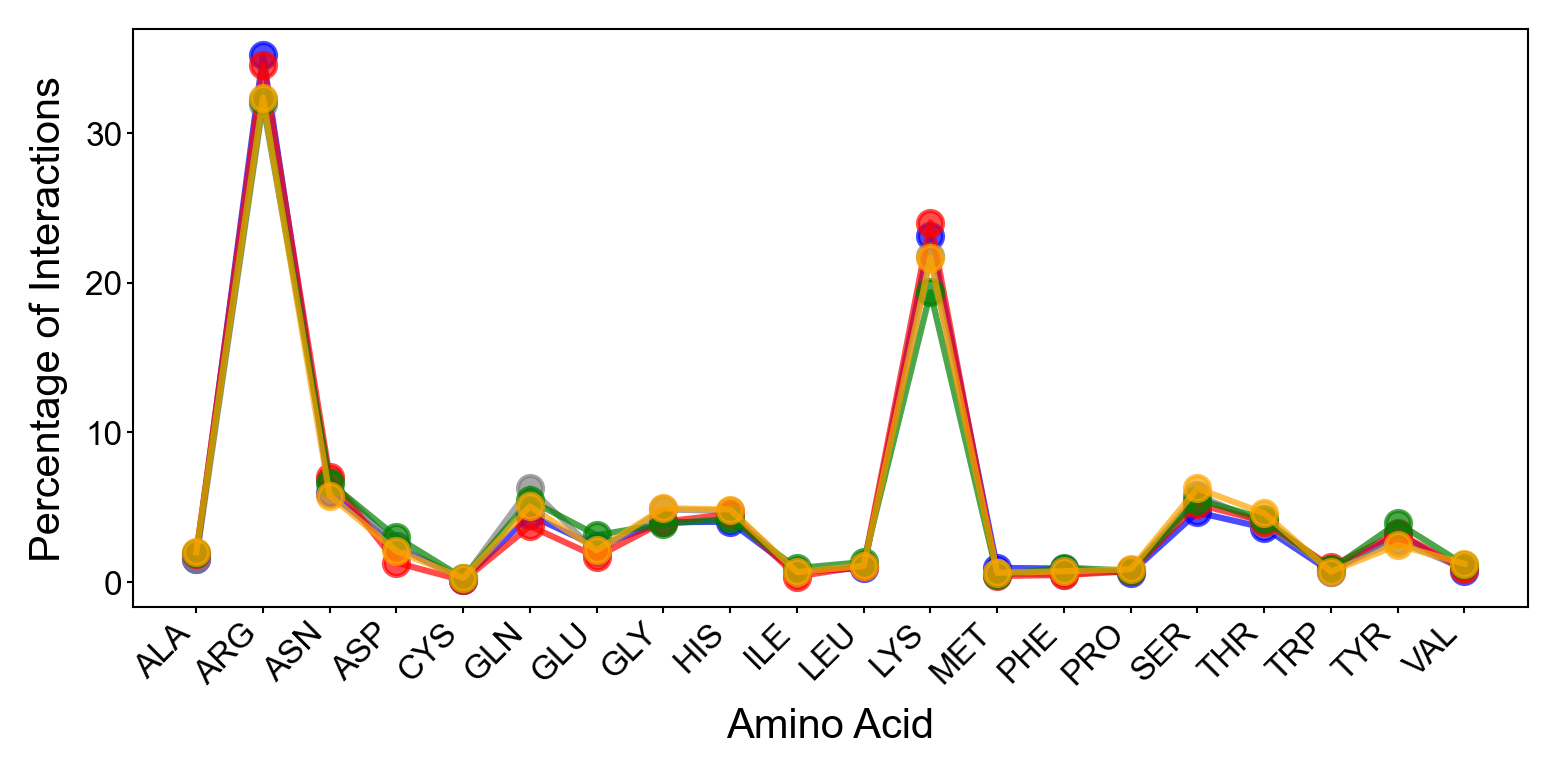

In [15]:
# Define colors for each motif type
colors = {
    "HELIX": "gray",
    "NWAY": "red", 
    "TWOWAY": "orange",
    "HAIRPIN": "blue",
    "SSTRAND": "green",
}

# Calculate percentage of interactions for each mtype and amino acid
df_pct = df_hbonds.groupby(['mtype', 'aa']).size().unstack(fill_value=0)
df_pct = df_pct.div(df_pct.sum(axis=1), axis=0) * 100

# Get unique mtypes for colors
mtypes = df_pct.index.unique()

# Create the plot
fig, ax = plt.subplots(figsize=(6.0,2.5), dpi=300)

# Plot a line for each mtype
for mtype in mtypes:
    ax.plot(df_pct.columns, df_pct.loc[mtype],
            label=mtype, marker='o', alpha=0.7,
            color=colors[mtype])

ax.set_xticks(range(len(df_pct.columns)))
ax.set_xticklabels(df_pct.columns, rotation=45, ha='right')
ax.set_xlabel('Amino Acid')
ax.set_ylabel('Percentage of Interactions')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
publication_style_ax(ax)


/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_5278/3155339552.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mtype_totals.index, rotation=45, ha='right')


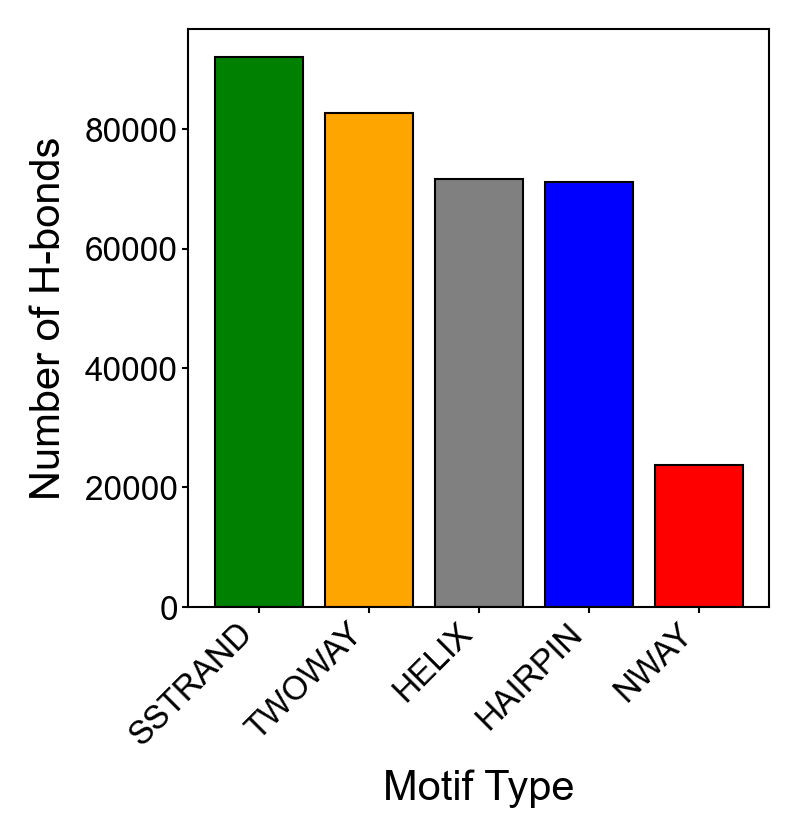

In [16]:
# Calculate total H-bonds per motif type
mtype_totals = df_hbonds['mtype'].value_counts()

# Create bar plot
fig, ax = plt.subplots(figsize=(2.5,2.5), dpi=300)

# Plot bars with same colors as previous plot
bars = ax.bar(mtype_totals.index, mtype_totals.values, 
              color=[colors[mtype] for mtype in mtype_totals.index],
              edgecolor='black', linewidth=0.5)

ax.set_xlabel('Motif Type')
ax.set_ylabel('Number of H-bonds')
ax.set_xticklabels(mtype_totals.index, rotation=45, ha='right')

publication_style_ax(ax)


In [17]:
def get_sub_df(df, res_1, res_2, atom_1, atom_2):
    return df.query("res_type_1 == @res_1 and res_type_2 == @res_2 and atom_1 == @atom_1 and atom_2 == @atom_2")



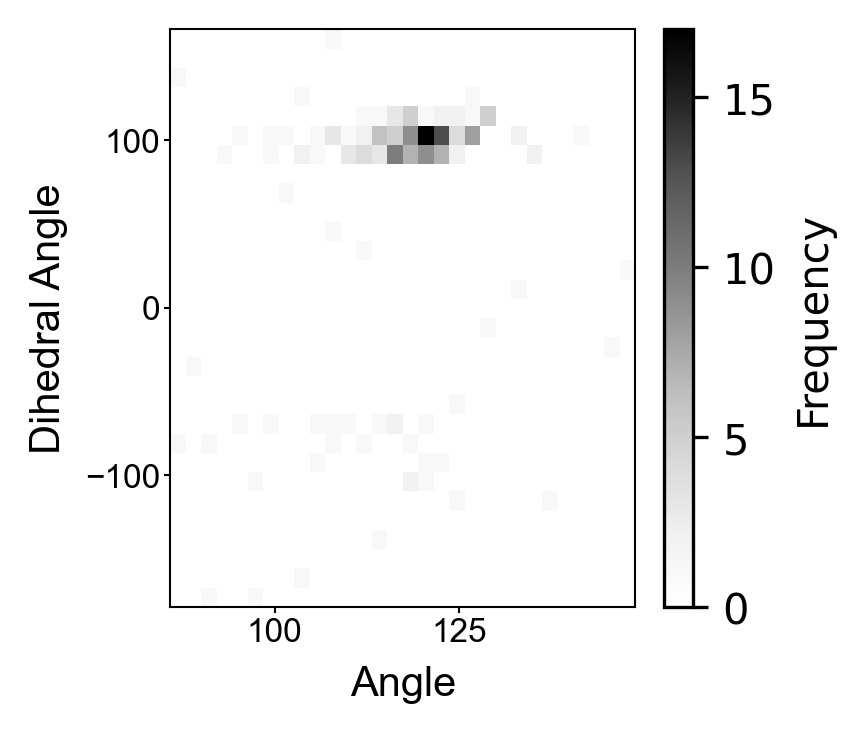

In [18]:
df_sub = get_sub_df(df, "A", "ALA", "O4'", "N")
fig, ax = plt.subplots(figsize=(2.5,2.5), dpi=300)
hist = ax.hist2d(df_sub["angle_1"], df_sub["dihedral_angle"], bins=30, cmap="Greys")
plt.colorbar(hist[3], ax=ax, label="Frequency")
ax.set_xlabel("Angle")
ax.set_ylabel("Dihedral Angle")
publication_style_ax(ax)